# create figures for HOT1A3 DE long term 

In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")
library(corrplot)
library(circlize)

Warning message:
"package 'DESeq2' was built under R version 4.2.2"
Loading required package: S4Vectors

Warning message:
"package 'S4Vectors' was built under R version 4.2.2"
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
"package 'BiocGenerics' was built under R version 4.2.1"

Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    exp

In [2]:
library(scales)

Warning message:
"package 'scales' was built under R version 4.2.1"

Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor




In [3]:
library(ggrepel)

Warning message:
"package 'ggrepel' was built under R version 4.2.1"


In [4]:
status_palette <- c(
  "Up" = "#CC79A7",        # Green
  "Down" = "#009E73",      # Red
  "DE" = "#0072B2",      # Red
  "Unchanged" = "#e8ecec", # Gray
  "N/A" = "#bfc8c9"        # Light Yellow
)

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [6]:
df_all_orig = read_csv(file.path('..', 'Enrichment','DE_results', 'HOT1A3_all_FC_results.csv'))



Warning message:
"One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 53457 Columns: 33
── Column specification ────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (22): contrast, protein_id, Assay, contrast1, Name, gene, locus_tag, old...
dbl  (7): logFC, AveExpr, pvalue, padj, start, end, gene_length
lgl  (4): Note, exception, down, up

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
t(head(df_all_orig,2))

contrast,C2 - C1,C2 - C1
protein_id,WP_011132009.1,WP_011132596.1
logFC,2.602933,1.795646
AveExpr,0.9167156,2.0464881
pvalue,5.951467e-07,8.763244e-07
padj,0.0004868287,0.0004868287
Assay,Proteome,Proteome
contrast1,C2vsC1_prot,C2vsC1_prot
Name,TX50_RS01980,ureC
gene,NA,ureC
locus_tag,TX50_RS01980,TX50_RS05125


In [8]:
dput(sort(unique(df_all_orig$contrast1)))


c("C1vsP1_rna", "C2vsC1_prot", "C2vsC1_rna", "C3vsC1_prot", "C3vsC1_rna", 
"C3vsC2_prot", "C3vsC2_rna", "C4vsC1_prot", "C4vsC1_rna", "C4vsC2_prot", 
"C4vsC3_prot", "C4vsC3_rna", "C5vsC1_prot", "C5vsC1_rna", "C5vsC2_prot", 
"C5vsC3_prot", "C5vsC3_rna", "C5vsC4_prot", "C5vsC4_rna", "LATEvsC1_prot", 
"LATEvsC1_rna", "LATEvsC2_prot", "LATEvsC2_rna", "LATEvsC3_prot", 
"LATEvsC3_rna", "LATEvsP1_prot", "LATEvsP1_rna", "LATEvsP2_prot", 
"LATEvsP2_rna", "P2vsP1_prot", "P2vsP1_rna", "P3vsP1_prot", "P5vsP1_prot"
)


In [9]:
lookuptable = c(
    "C1vsP1_rna" = 'other',
    "C2vsC1_prot" = 'Limitation vs. Growth',
    "C2vsC1_rna" = 'Limitation vs. Growth', 
    "C3vsC1_prot" = 'other', 
    "C3vsC1_rna" = 'other', 
    "C3vsC2_rna" = 'day30 vs. Limitation',  # new
    "C3vsC2_prot" = 'day30 vs. Limitation', 
    "C4vsC1_prot" = 'other', 
    "C4vsC1_rna" = 'other', 
    "C4vsC2_prot" = 'other', 
    "C4vsC3_prot" = 'other', 
    "C4vsC3_rna" = 'other', 
    "C5vsC1_prot" = 'other', 
    "C5vsC1_rna" = 'other', 
    "C5vsC2_prot" = 'other', 
    "C5vsC3_prot" = 'other', 
    "C5vsC3_rna" = 'other', 
    "C5vsC4_prot" = 'Survival', 
    "C5vsC4_rna" = 'Survival', 
    "LATEvsC1_prot" = 'Survival vs. Growth', 
    "LATEvsC1_rna" = 'Survival vs. Growth', 
    "LATEvsC2_prot" = 'other', 
    "LATEvsC2_rna" = 'other', 
    "LATEvsC3_prot" = 'Survival vs. day30', 
    "LATEvsC3_rna" = 'Survival vs. day30', 
    "LATEvsP1_prot" = 'other', 
    "LATEvsP1_rna" = 'other', 
    "LATEvsP2_prot" = 'Decomposing vs. Death', 
    "LATEvsP2_rna" = 'Survival vs. Death', 
    "P2vsP1_prot" = 'Death vs. Growth',
    "P2vsP1_rna" = 'Death vs. Growth', 
    "P3vsP1_prot" = 'other', 
    "P5vsP1_prot" = 'other'
)

In [10]:
df_de_stats = df_all_orig %>% 
    mutate(is_de = padj < 0.05) %>%
    mutate(no_value = is.na(padj)) %>%
    group_by(Assay,contrast1) %>%
    summarise(
        Up=sum(up, na.rm = TRUE),
        Down=sum(down, na.rm = TRUE),
        #DE=sum(is_de, na.rm = TRUE),
        Unchanged=sum(!is_de, na.rm = TRUE),
        'N/A'=sum(no_value, na.rm = TRUE),
       # Total=n(),        
    )
df_de_stats

`summarise()` has grouped output by 'Assay'. You can override using the `.groups` argument.


Assay,contrast1,Up,Down,Unchanged,N/A
<chr>,<chr>,<int>,<int>,<int>,<int>
Proteome,C2vsC1_prot,106,50,1268,0
Proteome,C3vsC1_prot,242,251,931,0
Proteome,C3vsC2_prot,27,55,1342,0
Proteome,C4vsC1_prot,225,203,996,0
Proteome,C4vsC2_prot,193,208,1023,0
Proteome,C4vsC3_prot,179,133,1112,0
Proteome,C5vsC1_prot,241,263,920,0
Proteome,C5vsC2_prot,244,280,900,0
Proteome,C5vsC3_prot,212,236,976,0


In [11]:
df_de_stats_category = df_all_orig %>% 
    mutate(is_de = padj < 0.05) %>%
    mutate(no_value = is.na(padj)) %>%
    group_by(Assay,contrast1, Category) %>%
    summarise(
        Up=sum(up, na.rm = TRUE),
        Down=sum(down, na.rm = TRUE),
        #DE=sum(is_de, na.rm = TRUE),
        Unchanged=sum(!is_de, na.rm = TRUE),
        'N/A'=sum(no_value, na.rm = TRUE),
        #Total=n(),        
        
    )
df_de_stats_category

`summarise()` has grouped output by 'Assay', 'contrast1'. You can override using the `.groups` argument.


Assay,contrast1,Category,Up,Down,Unchanged,N/A
<chr>,<chr>,<chr>,<int>,<int>,<int>,<int>
Proteome,C2vsC1_prot,AA/Nucleotide,16,0,143,0
Proteome,C2vsC1_prot,AA/Nucleotide;Energy/Carbohydrate/Glycan,6,2,28,0
Proteome,C2vsC1_prot,Energy/Carbohydrate/Glycan,10,3,78,0
Proteome,C2vsC1_prot,Env. Info/Cellular Process,1,2,31,0
Proteome,C2vsC1_prot,Genetic Info,17,21,220,0
Proteome,C2vsC1_prot,Membrane transport,8,2,62,0
Proteome,C2vsC1_prot,Metabolism,8,9,156,0
Proteome,C2vsC1_prot,Nitrogen metabolism,6,0,0,0
Proteome,C2vsC1_prot,Other,24,5,323,0


In [12]:
mdf_de_stats= pivot_longer(
    df_de_stats, !Assay & !contrast1,  names_to = 'Status', values_to = 'n'
)

In [13]:
mdf_de_stats = mdf_de_stats %>% mutate(comparison = lookuptable[contrast1])

In [14]:
mdf_de_stats_category = pivot_longer(
    df_de_stats_category, !Assay & !contrast1 & !Category,  names_to = 'Status', values_to = 'n'
)

In [15]:
mdf_de_stats_category = mdf_de_stats_category %>% mutate(comparison = lookuptable[contrast1])

In [16]:
dput(unique(mdf_de_stats$Status))

c("Up", "Down", "Unchanged", "N/A")


In [17]:
mdf_de_stats = mdf_de_stats %>%
    #mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))
    mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))

In [18]:
mdf_de_stats_category = mdf_de_stats_category %>%
    #mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))
    mutate(Status = factor(Status, levels = c("Up", "Down", "Unchanged", "N/A")))

# Create bar charts

In [19]:
options(repr.plot.width = 5, repr.plot.height = 3, repr.plot.res = 300)

Warning message:
"Removed 8 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 8 rows containing missing values (`geom_text()`)."


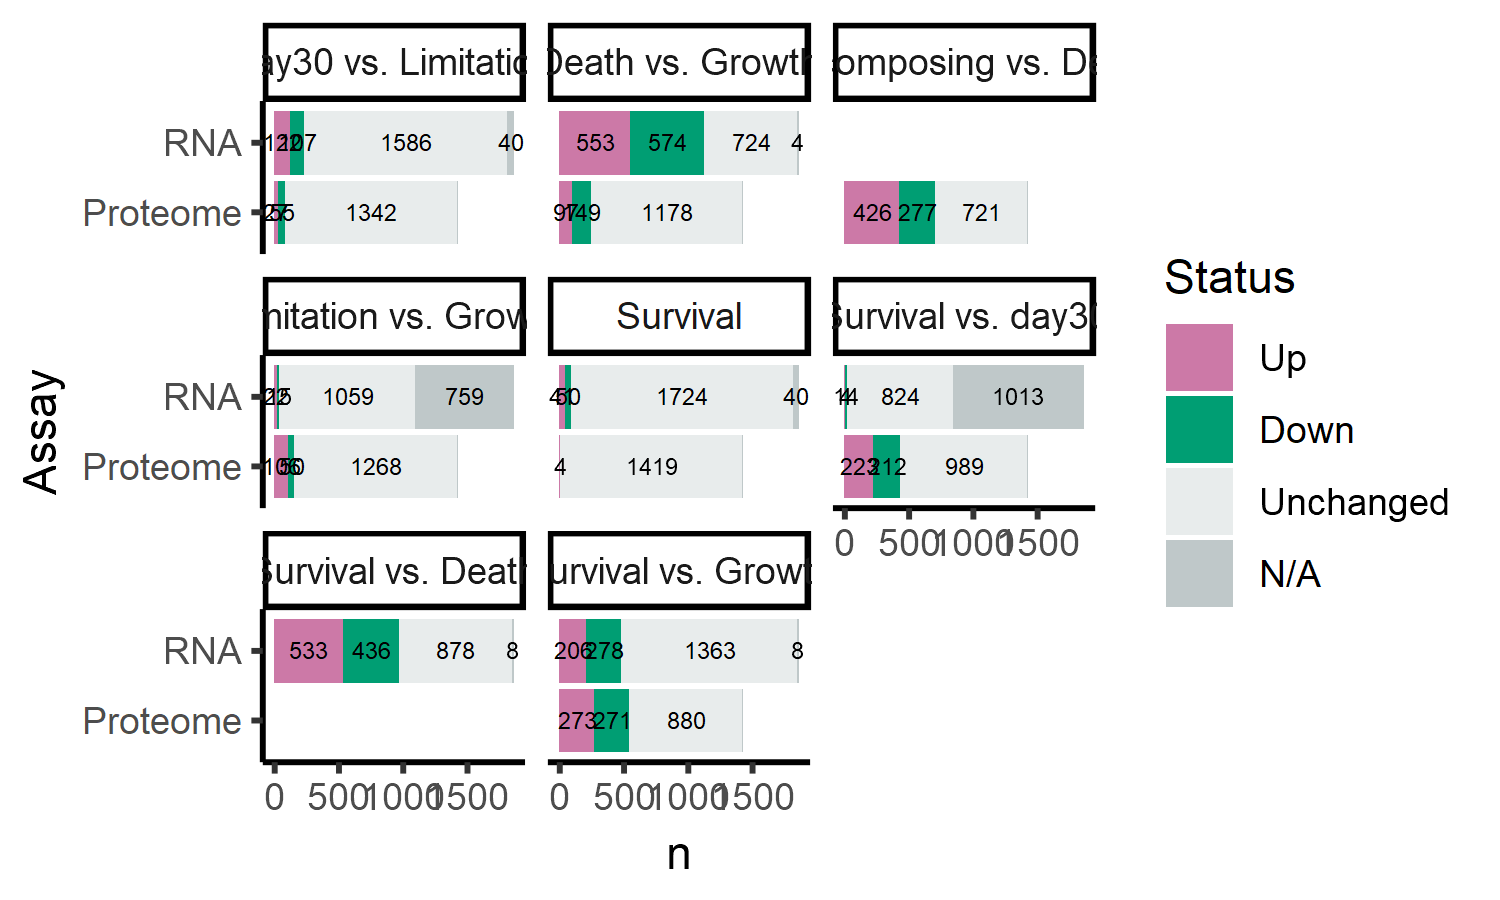

In [20]:
ggplot(mdf_de_stats %>% filter(comparison != 'other'), aes(y = Assay, x = n, fill = Status)) +
  geom_col(position = position_stack(reverse = TRUE)) +
  scale_fill_manual(values = status_palette) +
 
  geom_text(
    aes(label = ifelse(n < 3, NA, n)),
    position = position_stack(reverse = TRUE, vjust = 0.5),
   # check_overlap = TRUE,
      size=2,
  ) +
    facet_wrap(~comparison, ncol = 3) +
    theme_classic()
  #labs(title = "Stacked Bar Chart with Labels")
ggsave('figures/HOT1A3_degenes_bars.svg', height = 3, width = 5)

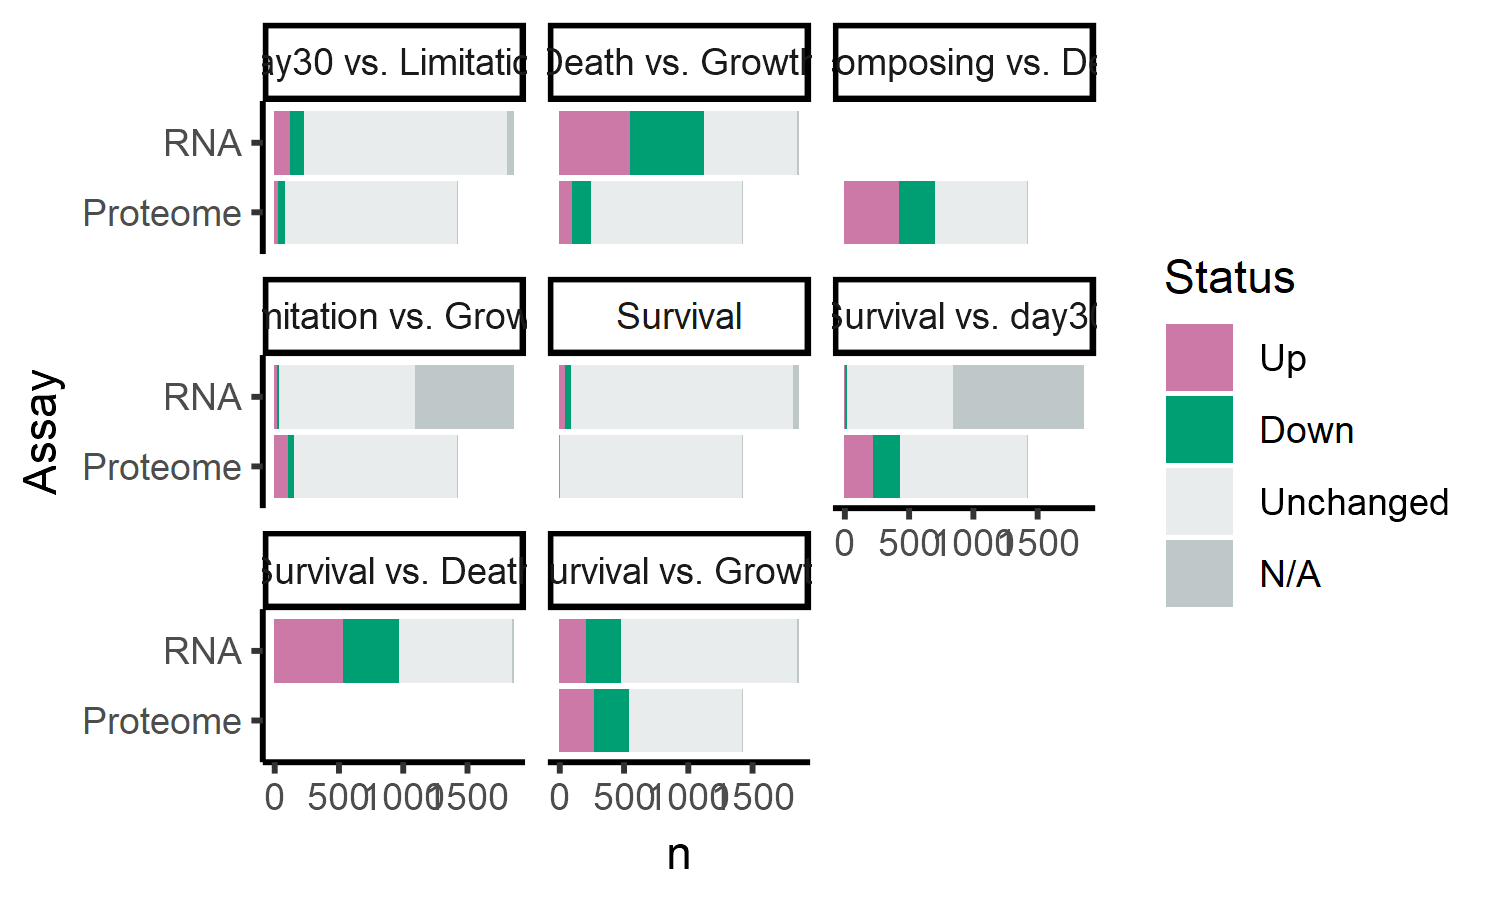

In [21]:
ggplot(mdf_de_stats %>% filter(comparison != 'other'), aes(y = Assay, x = n, fill = Status)) +
  geom_col(position = position_stack(reverse = TRUE)) +
  scale_fill_manual(values = status_palette) +
 
  # geom_text(
  #   aes(label = ifelse(n < 3, NA, n)),
  #   position = position_stack(reverse = TRUE, vjust = 0.5),
  #  # check_overlap = TRUE,
  #     size=2,
  # ) +
    facet_wrap(~comparison, ncol = 3) +
    theme_classic()
  #labs(title = "Stacked Bar Chart with Labels")
ggsave('figures/HOT1A3_degenes_bars_notext.svg', height = 3, width = 5)

In [22]:
dput(unique(mdf_de_stats$comparison))

c("Limitation vs. Growth", "other", "day30 vs. Limitation", "Survival", 
"Survival vs. Growth", "Survival vs. day30", "Decomposing vs. Death", 
"Death vs. Growth", "Survival vs. Death")


In [23]:
dput(unique(mdf_de_stats_category$Category))
dput(unique(mdf_de_stats_category$comparison))
mdf_de_stats_category = mdf_de_stats_category %>%
    mutate(
        Category = factor(Category, levels=c(
            "Photosynthesis/Carbon fixation", 
            "high light inducible",        
            "Energy/Carbohydrate/Glycan", 
            "AA/Nucleotide;Energy/Carbohydrate/Glycan", 
            "AA/Nucleotide", 
            "Nitrogen metabolism", 
            "Metabolism", 
            "Membrane transport", 
            "Env. Info/Cellular Process", 
            "Genetic Info", 
            "Other",
            "Uncharacterized"
        )),
        comparison = factor(comparison, levels=c(
            "Death vs. Growth", 
            "Limitation vs. Growth", 
            "day30 vs. Limitation", 
            "Survival vs. day30", 
            "Survival vs. Growth", 
            "Survival vs. Death",
            "Decomposing vs. Death", 
            "Survival",
            "other"
        ))
    )

c("AA/Nucleotide", "AA/Nucleotide;Energy/Carbohydrate/Glycan", 
"Energy/Carbohydrate/Glycan", "Env. Info/Cellular Process", "Genetic Info", 
"Membrane transport", "Metabolism", "Nitrogen metabolism", "Other", 
"Photosynthesis/Carbon fixation", "Uncharacterized", "high light inducible"
)
c("Limitation vs. Growth", "other", "day30 vs. Limitation", "Survival", 
"Survival vs. Growth", "Survival vs. day30", "Decomposing vs. Death", 
"Death vs. Growth", "Survival vs. Death")


Warning message:
"Removed 285 rows containing missing values (`geom_text()`)."
Warning message:
"Removed 285 rows containing missing values (`geom_text()`)."


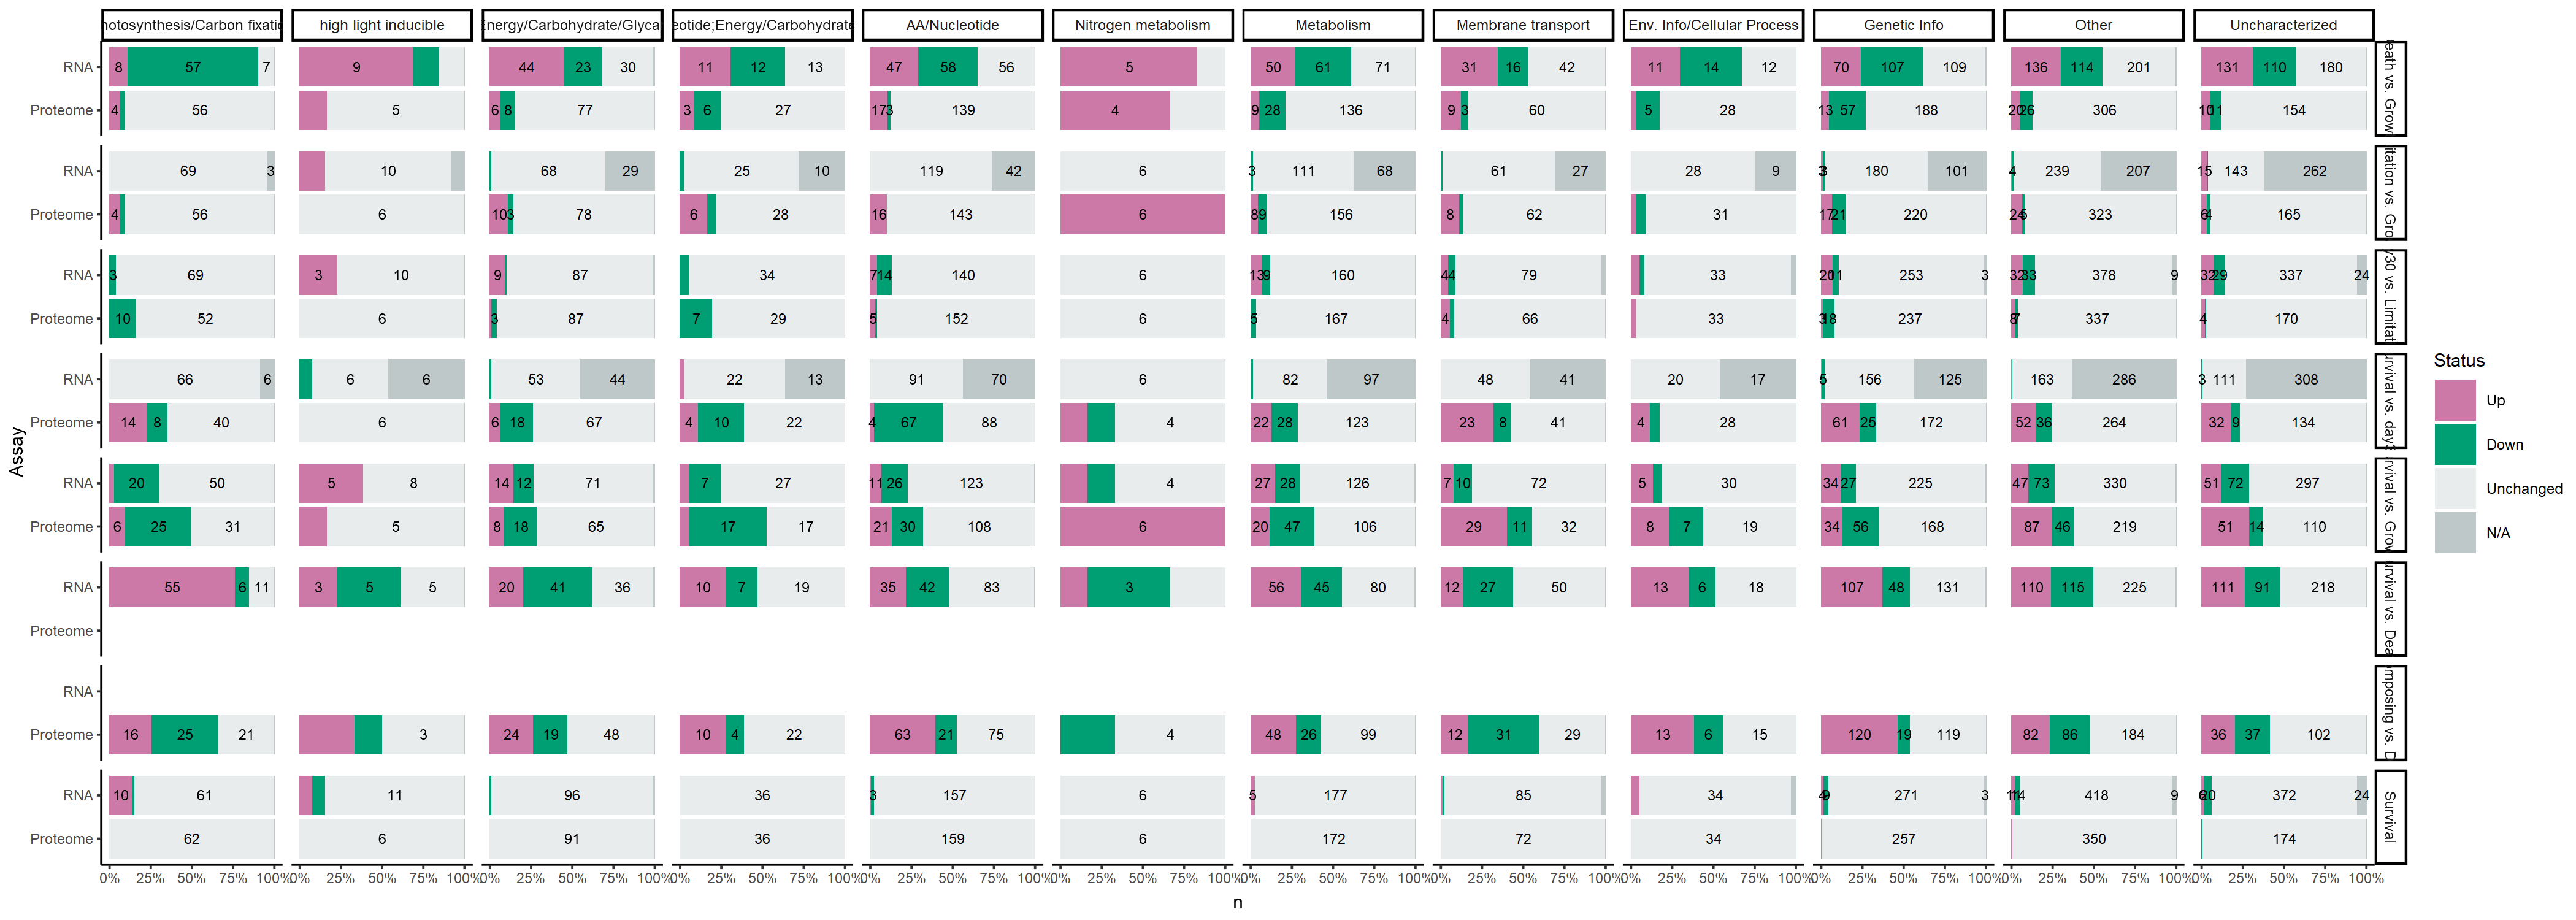

In [24]:
options(repr.plot.width = 14, repr.plot.height = 5, repr.plot.res = 300)

ggplot(mdf_de_stats_category %>% filter(comparison != 'other'), aes(y = Assay, x = n, fill = Status)) +
  geom_col(position = position_fill(reverse = TRUE)) +
  scale_fill_manual(values = status_palette) +
 
  geom_text(
    aes(label = ifelse(n < 3, NA, n)),
    position = position_fill(reverse = TRUE, vjust = 0.5),
   # check_overlap = TRUE,
      size=2,
  ) +
    facet_grid(rows=vars(comparison), cols=vars(Category)) +
    scale_x_continuous(labels = label_percent()) +
    theme_classic(base_size=7)
  #labs(title = "Stacked Bar Chart with Labels")
ggsave('figures/HOT1A3_degenes_category_bars.svg', height = 4, width = 10)

In [25]:
mdf_de_stats %>% filter(comparison != 'other') %>% count(comparison, contrast1)

Assay,comparison,contrast1,n
<chr>,<chr>,<chr>,<int>
Proteome,Death vs. Growth,P2vsP1_prot,4
Proteome,Decomposing vs. Death,LATEvsP2_prot,4
Proteome,Limitation vs. Growth,C2vsC1_prot,4
Proteome,Survival,C5vsC4_prot,4
Proteome,Survival vs. Growth,LATEvsC1_prot,4
Proteome,Survival vs. day30,LATEvsC3_prot,4
Proteome,day30 vs. Limitation,C3vsC2_prot,4
RNA,Death vs. Growth,P2vsP1_rna,4
RNA,Limitation vs. Growth,C2vsC1_rna,4


In [26]:
unique(df_all_orig$Category)

[1] "Nitrogen metabolism"                     
 [2] "AA/Nucleotide"                           
 [3] "Photosynthesis/Carbon fixation"          
 [4] "Membrane transport"                      
 [5] "Genetic Info"                            
 [6] "Other"                                   
 [7] "Env. Info/Cellular Process"              
 [8] "Metabolism"                              
 [9] "Energy/Carbohydrate/Glycan"              
[10] "AA/Nucleotide;Energy/Carbohydrate/Glycan"
[11] "Uncharacterized"                         
[12] "high light inducible"

In [27]:
help(theme_classic)

ggtheme {ggplot2},R Documentation
base_size,"base font size, given in pts."
base_family,base font family
base_line_size,base size for line elements
base_rect_size,base size for rect elements
